# Explainable Deep Learning

The need for explainable deep learning has led to the devel- opment of a variety of methods that can help us better understand the decisions and decision-making process of neural network models.

## Install and Load Packages

In [1]:
%%capture install_log
!pip install captum
!pip install scikit-learn==0.23.0
!pip install tf-keras-vis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import copy
import sys
import numpy as np
from tqdm import tqdm

import cv2
import skimage.io 
import skimage.segmentation
from skimage.color import gray2rgb, rgb2gray, label2rgb
from skimage.transform import resize
from captum.attr import visualization as viz
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.autograd import Function

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, RMSprop

import warnings
warnings.filterwarnings('ignore')

## Load data and train Pytorch model (to be explained)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



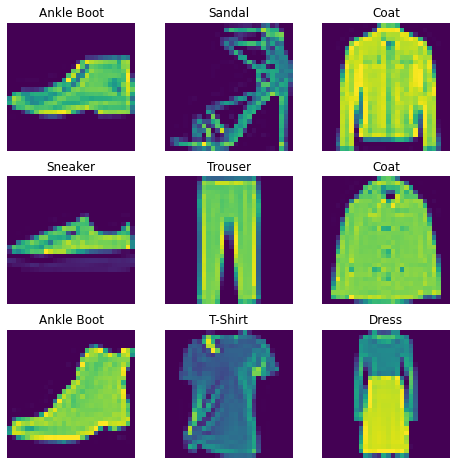

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

BATCH_SIZE = 4

train_dataloader = DataLoader(training_data, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
for epoch in range(2):  # loop over the dataset

    correct = 0
    for i, data in enumerate(train_dataloader, 0):
  
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss = loss.item()
        # if i % 50 == 0:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0

        predicted = torch.max(outputs.data, 1)[1] 
        correct += (predicted == labels).sum()
        #print(correct.item())
        if i % 1000 == 999:
            print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                epoch, i*len(data[0]), len(train_dataloader.dataset), 100.*i / len(train_dataloader), running_loss, float(correct*100) / float(BATCH_SIZE*(i+1))))

correct = 0 
for test_imgs, test_labels in test_dataloader:
    output = model(test_imgs)
    predicted = torch.max(output,1)[1]
    correct += (predicted == test_labels).sum()
print()
print("Test accuracy:{:.3f}% ".format( 100*float(correct) / (len(test_dataloader)*BATCH_SIZE)))


Epoch : 0 [3996/60000 (7%)]	Loss: 1.515472	 Accuracy:26.675%
Epoch : 0 [7996/60000 (13%)]	Loss: 1.205604	 Accuracy:41.938%
Epoch : 0 [11996/60000 (20%)]	Loss: 0.060397	 Accuracy:50.300%
Epoch : 0 [15996/60000 (27%)]	Loss: 0.127718	 Accuracy:55.062%
Epoch : 0 [19996/60000 (33%)]	Loss: 0.213290	 Accuracy:58.305%
Epoch : 0 [23996/60000 (40%)]	Loss: 0.361234	 Accuracy:60.812%
Epoch : 0 [27996/60000 (47%)]	Loss: 0.774624	 Accuracy:62.496%
Epoch : 0 [31996/60000 (53%)]	Loss: 0.429250	 Accuracy:63.888%
Epoch : 0 [35996/60000 (60%)]	Loss: 0.748411	 Accuracy:65.175%
Epoch : 0 [39996/60000 (67%)]	Loss: 0.098265	 Accuracy:66.260%
Epoch : 0 [43996/60000 (73%)]	Loss: 1.150489	 Accuracy:67.193%
Epoch : 0 [47996/60000 (80%)]	Loss: 0.852340	 Accuracy:68.052%
Epoch : 0 [51996/60000 (87%)]	Loss: 0.731239	 Accuracy:68.810%
Epoch : 0 [55996/60000 (93%)]	Loss: 0.481301	 Accuracy:69.438%
Epoch : 0 [59996/60000 (100%)]	Loss: 0.613120	 Accuracy:70.038%
Epoch : 1 [3996/60000 (7%)]	Loss: 0.103948	 Accuracy:79.1

## Load data and train Keras Model (to be explained)

In [6]:
num_classes = 10
input_shape = (28, 28, 1)

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

4431872/4422102 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
def define_model():
  model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
  )
  model.summary()
  return model

class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = define_model()
        self.input_size = (28, 28)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

    def train(self,X_train,y_train):
        batch_size = 128
        epochs = 10

        self.model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        self.model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
 
K.clear_session()
keras_model = Model()
keras_model.train(X_train,y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

# LIME

Local Interpretable Model-agnostic Explanations (LIME) is a useful method for generating local explanations of a model for specific instances. As LIME is model-agnostic, it is applicable to a variety of neural networks. 

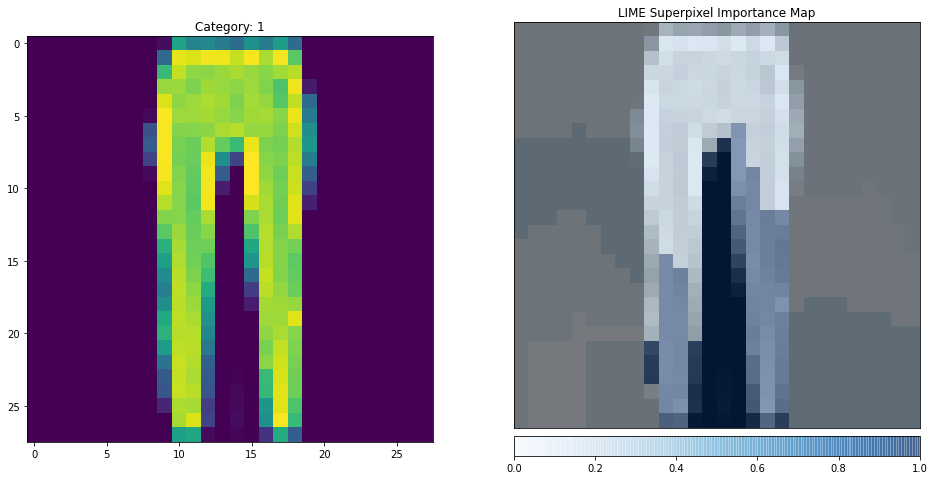

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3a86c3650>)

In [8]:
from captum.attr import Lime
from captum.attr import LimeBase
from captum._utils.models.linear_model import SkLearnLasso

image_index = 0
input = test_imgs[image_index].unsqueeze(1)

superpixels = skimage.segmentation.quickshift(gray2rgb(input.squeeze()), kernel_size=1,max_dist=20, ratio=.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

lime = Lime(model, interpretable_model=SkLearnLasso(alpha=0.00))
attr = lime.attribute(input, target=1,feature_mask=torch.from_numpy(superpixels))


fig, ax = plt.subplots(1,2,figsize = (16, 10))
ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="blended_heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="absolute_value",
                             fig_size=(8,8),
                             title='LIME Superpixel Importance Map',
                             show_colorbar=True)




# Occlusion

Perhaps one of the easiest ways to perturb an instance, occlusion (also named feature ablation) is a local method by which the input features of an instance are sequentially replaced with a constant.

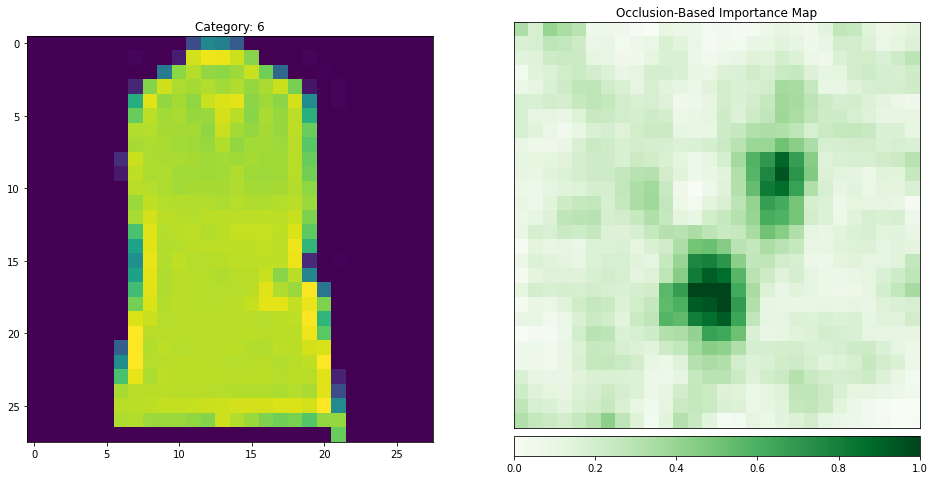

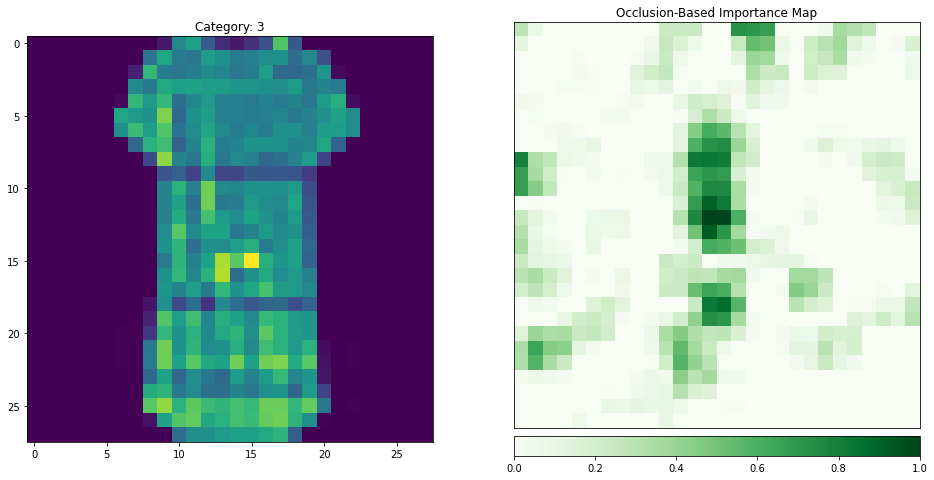

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3a8458ed0>)

In [9]:
from captum.attr import Occlusion

image_index = 2

# Generating random input with size 2 x 4 x 4
input = test_imgs[image_index].unsqueeze(1)
# Defining Occlusion interpreter
ablator = Occlusion(model)
# Computes occlusion attribution, ablating each 3x3 patch,
# shifting in each direction by the default of 1.
attr = ablator.attribute(input, target=test_labels[image_index].item(),sliding_window_shapes=tuple([1,3,3]))

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="positive",
                             fig_size=(8,8),
                             title='Occlusion-Based Importance Map',
                             show_colorbar=True)


image_index = 1

# Generating random input with size 2 x 4 x 4
input = test_imgs[image_index].unsqueeze(1)
# Defining Occlusion interpreter
ablator = Occlusion(model)
# Computes occlusion attribution, ablating each 3x3 patch,
# shifting in each direction by the default of 1.
attr = ablator.attribute(input, target=test_labels[image_index].item(),sliding_window_shapes=tuple([1,3,3]))

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="positive",
                             fig_size=(8,8),
                             title='Occlusion-Based Importance Map',
                             show_colorbar=True)


# RISE

The Random Input Sampling for Explanations (RISE) method is a generalized version of occlusion by probing a model with randomly masked portions of the input instance. 

In [10]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(keras_model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *keras_model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + keras_model.input_size[0], y:y + keras_model.input_size[1]]
    masks = masks.reshape(-1, *keras_model.input_size, 1)
    return masks


def explain(model, inp, masks):
    batch_size = 100
    preds = []
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(keras_model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *keras_model.input_size)
    sal = sal / N / p1
    return sal


def load_img(path):
    img = path
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x
    return img, x


Explaining: 100%|██████████| 20/20 [00:01<00:00, 12.81it/s]


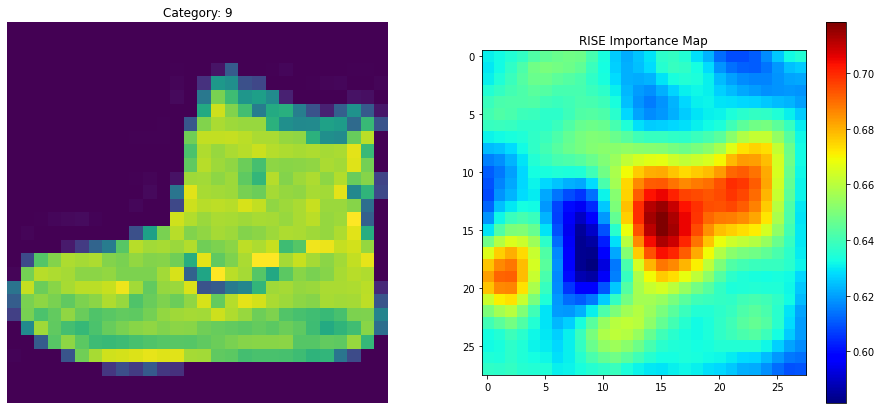

In [11]:
pic = 0

N = 2000
s = 8
p1 = 0.5

img, x = load_img(X_train[pic])
masks = generate_masks(N, s, p1)
explanation = explain(keras_model, x, masks)

class_idx = y_train[pic].argmax()
fig, ax = plt.subplots(1,2,figsize=(16,7))
ax[0].set_title('Category: {}'.format(class_idx))
ax[0].axis('off')
ax[0].imshow(img.squeeze())
fig2 = ax[1].imshow(explanation[class_idx], cmap='jet', alpha=1)
ax[1].set_title("RISE Importance Map")
plt.colorbar(fig2,ax=ax[1])
plt.show()

# Meaningful Perturbation

Meaningful Perturbation (MP) is a local explanation method based on a framework of meta-predictors to explain predictions for neural classifiers. These meta-predictors are trained predict the presence or absence of input features. Their prediction error is a measure of the faithfulness of the explanation.

In [12]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

def preprocess_image(img):
    preprocessed_img = img[None,...]
    if use_cuda:
      preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
      preprocessed_img_tensor = torch.from_numpy(preprocessed_img)

    preprocessed_img_tensor.unsqueeze_(0)
    return Variable(preprocessed_img_tensor, requires_grad = False)

def save(mask, img, blurred):
    mask = mask.cpu().data.numpy()[0]
    mask = np.transpose(mask, (1, 2, 0))

    mask = (mask - np.min(mask)) / np.max(mask)
    mask = 1 - mask
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = rgb2gray(1.0*heatmap) + np.float32(img)/255
    cam = cam / np.max(cam)

    img = np.float32(img) / 255
    perturbated = np.multiply(1 - mask, img) + np.multiply(mask, blurred)	

    cv2.imwrite("perturbated.png", np.uint8(255*perturbated))
    cv2.imwrite("heatmap.png", np.uint8(255*heatmap))
    cv2.imwrite("mask.png", np.uint8(255*mask))
    cv2.imwrite("cam.png", np.uint8(255*cam))

def numpy_to_torch(img, requires_grad = True):
    if len(img.shape) < 3:
      output = np.float32([img])
    else:
      output = np.transpose(img, (2, 0, 1))

    output = torch.from_numpy(output)
    if use_cuda:
      output = output.cuda()

    output.unsqueeze_(0)
    v = Variable(output, requires_grad = requires_grad)
    return v

def load_model():
    model.eval()
    if use_cuda:
      model.cuda()
    for p in model.features.parameters():
      p.requires_grad = False
    for p in model.classifier.parameters():
      p.requires_grad = False
    return model

Category with highest probability 3
Optimizing.. 


Text(0.5, 1.0, 'MP Heatmap')

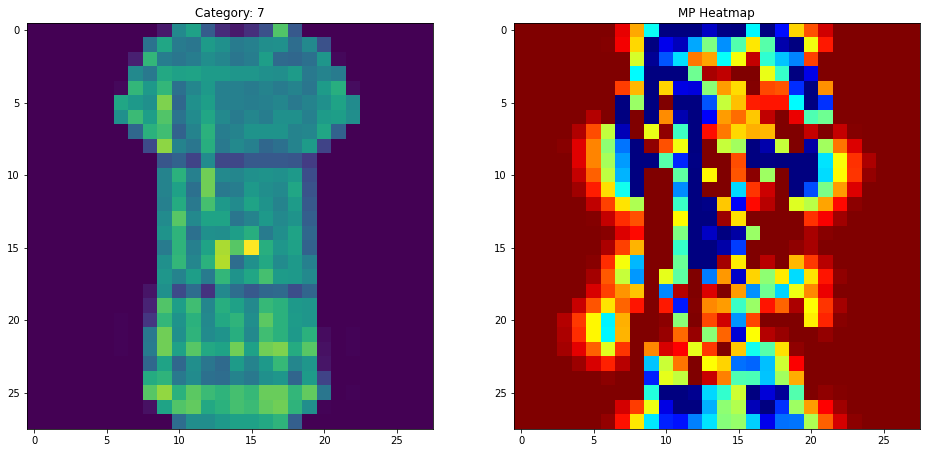

In [13]:
tv_beta = 3
learning_rate = 0.1
max_iterations = 500
l1_coeff = 0.01
tv_coeff = 0.2

img_index = 1

original_img = np.uint8(test_imgs[img_index].squeeze()*255)
img = np.float32(original_img) / 255
blurred_img1 = cv2.GaussianBlur(img, (3, 3), 5)
blurred_img2 = np.float32(cv2.medianBlur(np.array(original_img), 11))/255
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
mask_init = np.ones((28, 28), dtype = np.float32)

img = preprocess_image(img)
blurred_img = preprocess_image(blurred_img2)
mask = numpy_to_torch(mask_init)

if use_cuda:
  upsample = torch.nn.UpsamplingBilinear2d(size=(28, 28)).cuda()
else:
  upsample = torch.nn.UpsamplingBilinear2d(size=(28, 28))
optimizer = torch.optim.Adam([mask], lr=learning_rate)

target = torch.nn.Softmax()(model(img))
category = np.argmax(target.cpu().data.numpy())
print("Category with highest probability", category)
print("Optimizing.. ")

for i in range(max_iterations):
  upsampled_mask = upsample(mask)
  perturbated_input = img.mul(upsampled_mask) + \
            blurred_img.mul(1-upsampled_mask)
  
  noise = np.zeros((28, 28, 1), dtype = np.float32)
  cv2.randn(noise, 0, 0.2)
  noise = numpy_to_torch(noise)
  perturbated_input = perturbated_input + noise
  
  outputs = torch.nn.Softmax()(model(perturbated_input))
  loss = l1_coeff*torch.mean(torch.abs(1 - mask)) + \
      tv_coeff*tv_norm(mask, tv_beta) + outputs[0, category]

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  mask.data.clamp_(0, 1)

upsampled_mask = upsample(mask)
mask = upsampled_mask.cpu().data.numpy()[0]
mask = np.transpose(mask, (1, 2, 0)).squeeze()

mask = (mask - np.min(mask)) / np.max(mask)
mask = 1 - mask
heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
cam = rgb2gray(1.0*heatmap) + np.float32(original_img)/255
cam = cam / np.max(cam)

img = np.float32(img) / 255
perturbated = np.multiply(1 - mask, original_img) + np.multiply(mask, blurred_img_numpy)	

perturbed_img =  np.uint8(255*perturbated)
heatmap_img =  np.uint8(255*heatmap)
mask_img =  np.uint8(255*mask)
cam_img =  np.uint8(255*cam)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,16))

ax1.imshow(original_img)
ax1.set_title("Category: 7")

ax2.imshow(heatmap_img)
ax2.set_title("MP Heatmap")

# Activation Maximization

One of the earliest global explanation methods is the Activation Maximization method, which visually identifies the input features that can create the greatest response in the output of specific neurons.

200/200 [==============================] - 4s 20ms/step - Score: 335.3640 - TotalVariation2D: 27.7576 - Norm: 28.8725


Text(0.5, 1.0, 'Action Maximization Heatmap: Category 5')

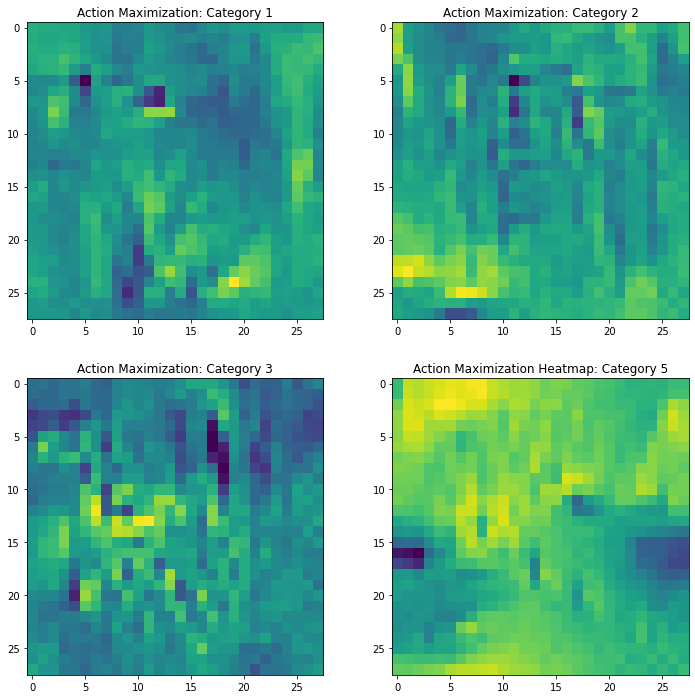

In [14]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

activation_maximization = \
   ActivationMaximization(keras_model.model,
                          model_modifier=[ExtractIntermediateLayer('dense'),
                                          ReplaceToLinear()],
                          clone=False)

activations = \
   activation_maximization(CategoricalScore([1]),
                           steps=200,
                           input_modifiers=[Jitter(jitter=2), Rotate2D(degree=1)],
                           regularizers=[TotalVariation2D(weight=1.0),
                                         Norm(weight=0.3, p=1)],
                           optimizer=RMSprop(1.0, 0.999),
                           callbacks=[Progress()])


fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(12,12))
ax1.imshow(activations[0].squeeze())
ax1.set_title("Action Maximization: Category 1")

activations = \
   activation_maximization(CategoricalScore([2]),
                           steps=200,
                           input_modifiers=[Jitter(jitter=2), Rotate2D(degree=1)],
                           regularizers=[TotalVariation2D(weight=1.0),
                                         Norm(weight=0.3, p=1)],
                           optimizer=RMSprop(1.0, 0.999),
                           callbacks=[Progress()])
   
ax2.imshow(activations[0].squeeze())
ax2.set_title("Action Maximization: Category 2")

activations = \
   activation_maximization(CategoricalScore([3]),
                           steps=200,
                           input_modifiers=[Jitter(jitter=2), Rotate2D(degree=1)],
                           regularizers=[TotalVariation2D(weight=1.0),
                                         Norm(weight=0.3, p=1)],
                           optimizer=RMSprop(1.0, 0.999),
                           callbacks=[Progress()])
   
ax3.imshow(activations[0].squeeze())
ax3.set_title("Action Maximization: Category 3")

activations = \
   activation_maximization(CategoricalScore([5]),
                           steps=200,
                           input_modifiers=[Jitter(jitter=2), Rotate2D(degree=1)],
                           regularizers=[TotalVariation2D(weight=1.0),
                                         Norm(weight=0.3, p=1)],
                           optimizer=RMSprop(1.0, 0.999),
                           callbacks=[Progress()])
   
ax4.imshow(activations[0].squeeze())
ax4.set_title("Action Maximization Heatmap: Category 5")


# Class Model Visualization

Activation maximization is the basis of class model visualizations. Class model visualizations have recently gained widespread attention for pioneering a new branch of deep learning-generated art called “deep dream” and “Inceptionism” based on the colorful visualizations of model classes.

In [15]:
def preprocess_image(pil_im, resize_im=False):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
#    mean = [0.485, 0.456, 0.406]
#    std = [0.229, 0.224, 0.225]
    mean = [0.485]
    std = [0.229]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im.squeeze())
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((28, 28), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr[...,None]
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
          im_as_arr[channel] /= 255.
    #     im_as_arr[channel].data -= mean[channel]
    #     im_as_arr[channel].data /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
#    reverse_mean = [-0.485, -0.456, -0.406]
#    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    reverse_mean = [-0.485]
    reverse_std = [1/0.229]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(1):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

class ClassSpecificImageGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent
    """
    def __init__(self, model, target_class):
#        self.mean = [-0.485, -0.456, -0.406]
#        self.std = [1/0.229, 1/0.224, 1/0.225]
        self.mean = [-0.485]
        self.std = [1/0.229]
        self.model = model
        self.model.eval()
        self.target_class = target_class
        # Generate a random image
        self.created_image = np.uint8(np.random.uniform(0, 255, (28, 28, 1)))
        # Create the folder to export images if not exists
        # if not os.path.exists('../generated/class_'+str(self.target_class)):
        #     os.makedirs('../generated/class_'+str(self.target_class))

    def generate(self, iterations=150):
        """Generates class specific image
        Keyword Arguments:
            iterations {int} -- Total iterations for gradient ascent (default: {150})
        Returns:
            np.ndarray -- Final maximally activated class image
        """
        initial_learning_rate = 2
        for i in range(1, iterations):
            # Process image and return variable
            self.processed_image = preprocess_image(self.created_image, False)

            # Define optimizer for the image
            optimizer = optim.SGD([self.processed_image], lr=initial_learning_rate)
            # Forward
 #           return self.processed_image
            output = self.model(self.processed_image)
            # Target specific class
            class_loss = -output[0, self.target_class]

            if i % 10 == 0 or i == iterations-1:
                print('Iteration:', str(i), 'Loss',
                      "{0:.2f}".format(class_loss.data.numpy()))
            # Zero grads
            self.model.zero_grad()
            # Backward
            class_loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # if i % 10 == 0 or i == iterations-1:
            #     # Save image
            #     im_path = '../generated/class_'+str(self.target_class)+'/c_'+str(self.target_class)+'_'+'iter_'+str(i)+'.png'
            #     save_image(self.created_image, im_path)

        return self.processed_image

Iteration: 10 Loss 2.22
Iteration: 20 Loss 1.79
Iteration: 30 Loss 2.11
Iteration: 40 Loss 1.80
Iteration: 50 Loss 2.20
Iteration: 60 Loss 1.88
Iteration: 70 Loss 2.23
Iteration: 80 Loss 1.86
Iteration: 90 Loss 2.24
Iteration: 100 Loss 1.75
Iteration: 110 Loss 2.21
Iteration: 120 Loss 1.80
Iteration: 130 Loss 2.25
Iteration: 140 Loss 1.70
Iteration: 149 Loss 0.00
Iteration: 10 Loss 0.72
Iteration: 20 Loss 0.35
Iteration: 30 Loss 0.34
Iteration: 40 Loss 0.33
Iteration: 50 Loss 0.32
Iteration: 60 Loss 0.30
Iteration: 70 Loss 0.31
Iteration: 80 Loss 0.27
Iteration: 90 Loss 0.27
Iteration: 100 Loss 0.28
Iteration: 110 Loss 0.33
Iteration: 120 Loss 0.38
Iteration: 130 Loss 0.23
Iteration: 140 Loss 0.26
Iteration: 149 Loss 1.41


Text(0.5, 1.0, 'Category: 4')

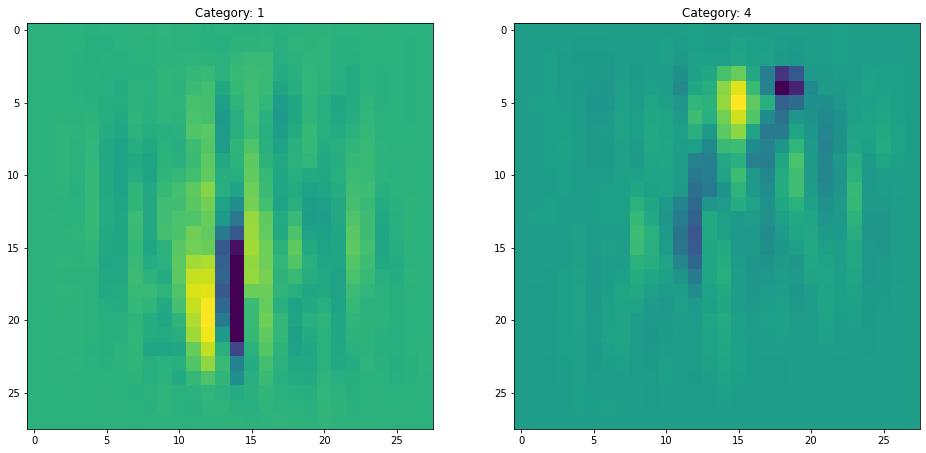

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,12))

target_class = 1
pretrained_model = model
csig = ClassSpecificImageGeneration(pretrained_model, target_class)
aa = csig.generate()
ax1.imshow(aa.detach().numpy().squeeze())
ax1.set_title("Category: 1")

target_class = 4
pretrained_model = model
csig = ClassSpecificImageGeneration(pretrained_model, target_class)
aa = csig.generate()
ax2.imshow(aa.detach().numpy().squeeze())
ax2.set_title("Category: 4")

    

# Saliency Maps

Saliency maps provide local explanations for specific instances. Instance-specific class saliency maps are extremely quick to compute and do not require any additional annotation to provide explanations. They do, however, require the scoring function to be differentiable.

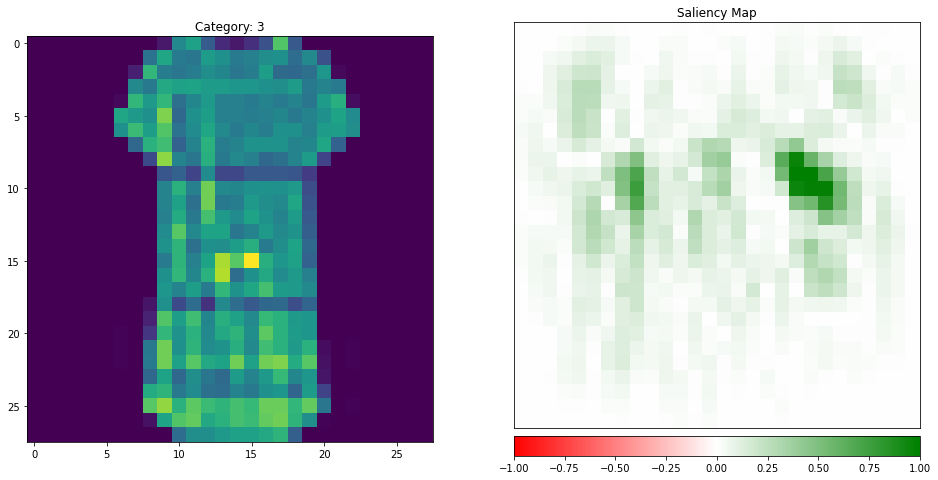

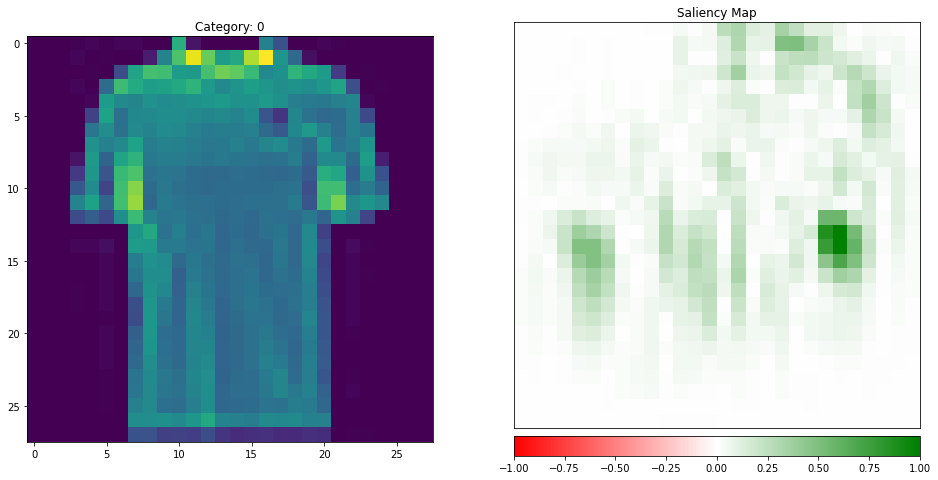

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd39ea1b490>)

In [17]:
from captum.attr import Saliency

image_index = 1

input = test_imgs[image_index].unsqueeze(1)
explainer = Saliency(model)

attr = explainer.attribute(input, target=test_labels[image_index].item())

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="all",
                             fig_size=(8,8),
                             title='Saliency Map',
                             show_colorbar=True)

image_index = 3

input = test_imgs[image_index].unsqueeze(1)
explainer = Saliency(model)

attr = explainer.attribute(input, target=test_labels[image_index].item())

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="all",
                             fig_size=(8,8),
                             title='Saliency Map',
                             show_colorbar=True)



# DeepLift

Deep Learning Important Features (DeepLIFT) is a recursive, local ex- planation method that decomposes a neural network model prediction for a specific instance by backpropagating the contributions of the neurons through the network. DeepLIFT is based on the difference between the activation of each neuron and its ‘reference activation’ in order to compute contribution scores.

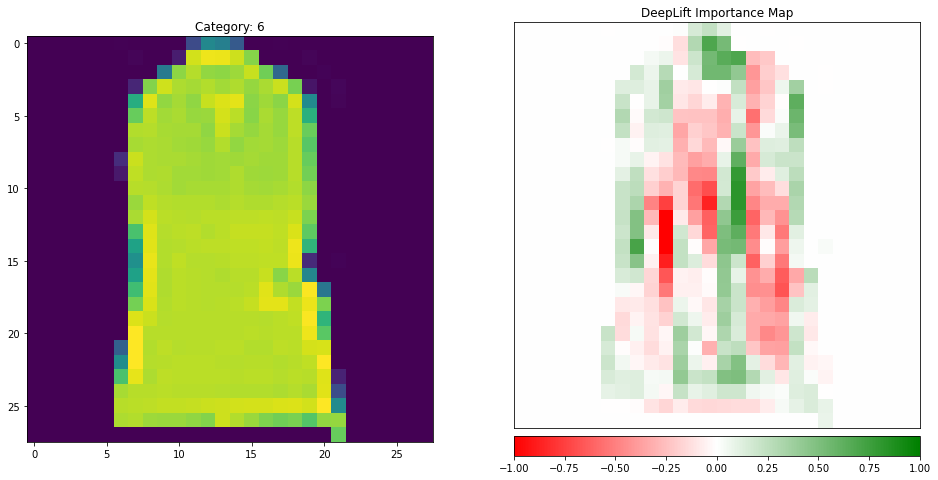

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd39e994050>)

In [18]:
from captum.attr import DeepLift

image_index = 2

input = test_imgs[image_index].unsqueeze(1)
explainer = DeepLift(model)

attr = explainer.attribute(input, target=test_labels[image_index].item())

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="all",
                             fig_size=(8,8),
                             title='DeepLift Importance Map',
                             show_colorbar=True)





# DeepSHAP

DeepSHAP is an extension of the KernelSHAP method by leveraging the compositional architecture of deep neural networks to improve com- putational efficiency. As previously mentioned, DeepLIFT per node attribution rules an approximate Shapley values. DeepSHAP leverages this approximation as well as DeepLIFT’s multiplier chain rule. 

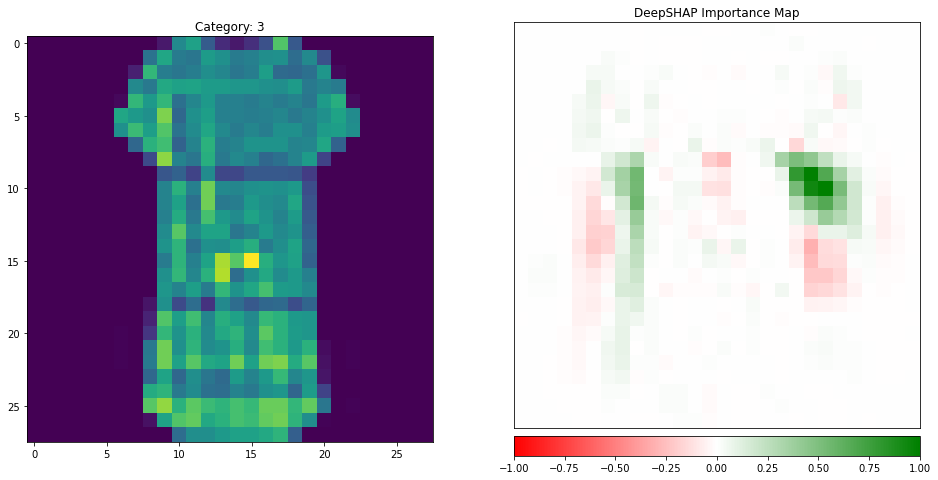

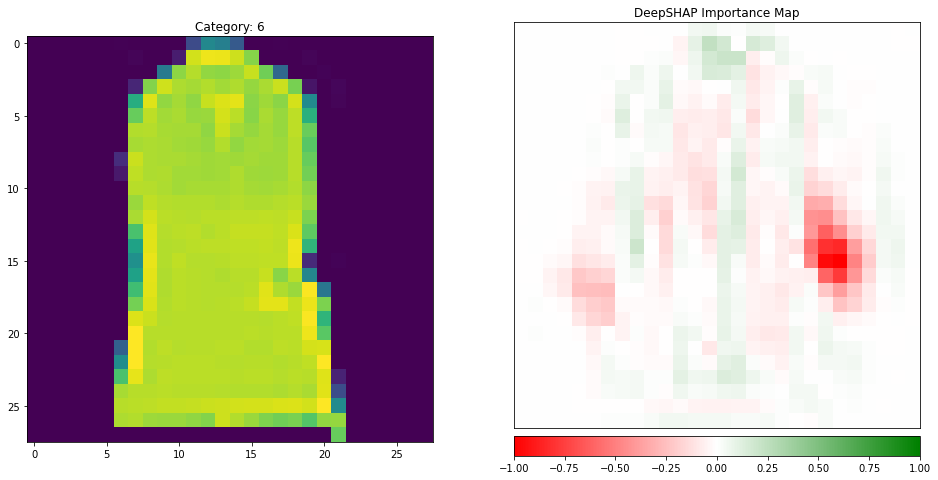

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd39d667950>)

In [19]:
from captum.attr import DeepLiftShap

image_index = 1

input = test_imgs[image_index].unsqueeze(1)
explainer = DeepLiftShap(model)

# Generate baseline samples
baseline_dataloader = DataLoader(training_data, 10, shuffle=True)
baselines, baseline_labels = next(iter(baseline_dataloader))

attr = explainer.attribute(input, target=test_labels[image_index].item(), baselines = baselines)

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="all",
                             fig_size=(8,8),
                             title='DeepSHAP Importance Map',
                             show_colorbar=True)


image_index = 2

input = test_imgs[image_index].unsqueeze(1)
explainer = DeepLiftShap(model)

# Generate baseline samples
baseline_dataloader = DataLoader(training_data, 10, shuffle=True)
baselines, baseline_labels = next(iter(baseline_dataloader))

attr = explainer.attribute(input, target=test_labels[image_index].item(), baselines = baselines)

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="all",
                             fig_size=(8,8),
                             title='DeepSHAP Importance Map',
                             show_colorbar=True)



# Deconvolution

Deconvolution is a explanation method proposed for visualizing the feature contributions of CNN architectures (convnets). It takes the output of the CNN and runs the CNN in reverse. The guiding notion is to determine which portions of an input instance is most discriminative for a single neuron.

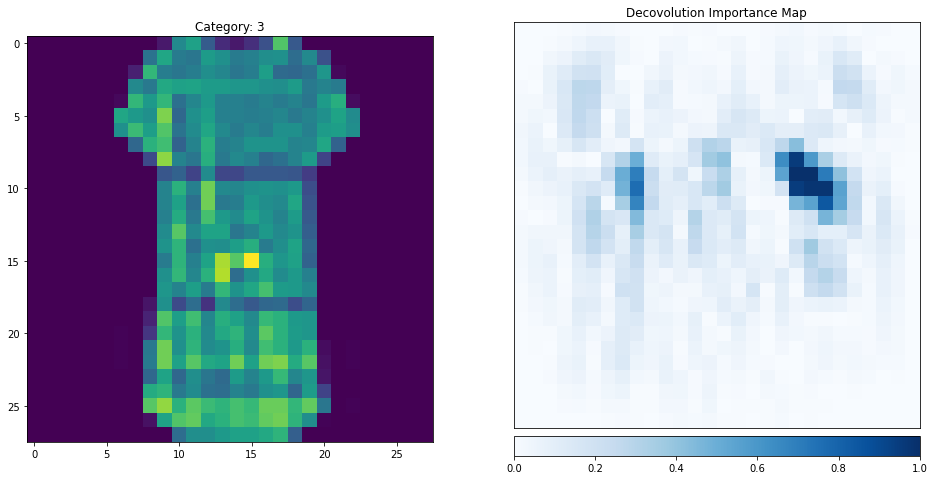

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd39d55bb90>)

In [20]:
from captum.attr import Deconvolution

image_index = 1

input = test_imgs[image_index].unsqueeze(1)
explainer = Deconvolution(model)

attr = explainer.attribute(input, target=test_labels[image_index].item())

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="absolute_value",
                             fig_size=(8,8),
                             title='Decovolution Importance Map',
                             show_colorbar=True)

# Guided Backpropagation

Guided Backpropagation is another explanation method for feature attri- bution on CNN-based architectures. It is similar to deconvolution, except it removes the unpooling operation and adopts a modified operation for the ReLU nonlinearity.

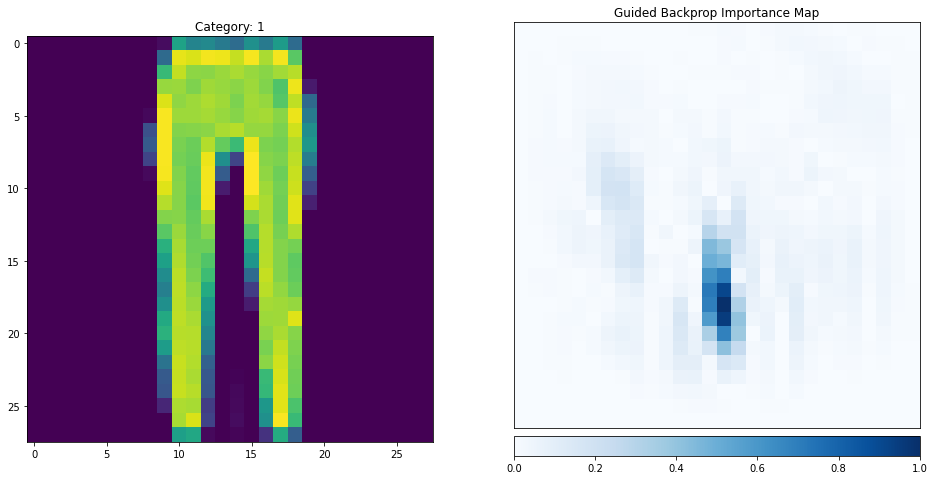

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd39d491750>)

In [21]:
from captum.attr import GuidedBackprop

image_index = 0

input = test_imgs[image_index].unsqueeze(1)
explainer = GuidedBackprop(model)

attr = explainer.attribute(input, target=test_labels[image_index].item())

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="absolute_value",
                             fig_size=(8,8),
                             title='Guided Backprop Importance Map',
                             show_colorbar=True)


# Integrated Gradients

Integrated gradients [SN19] is an explanation method that does not require modification of the original network and takes an axiomatic approach to generate feature attributions for specific instances.

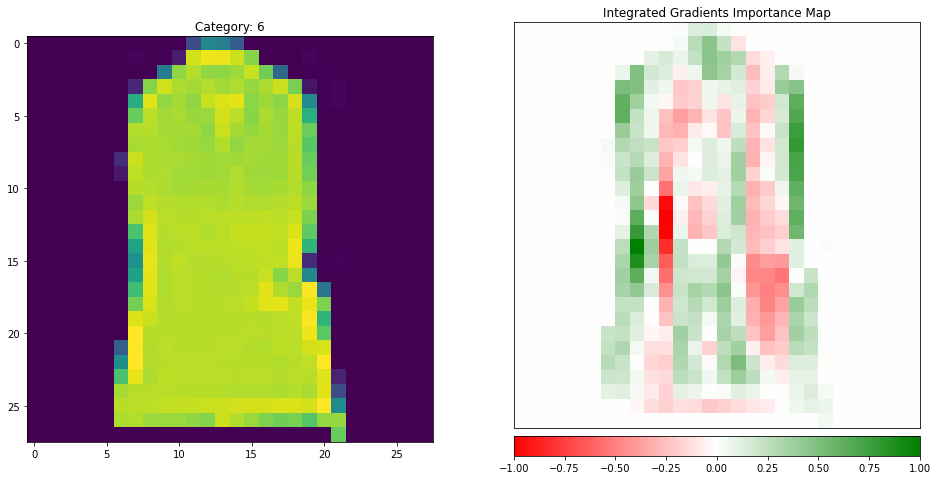

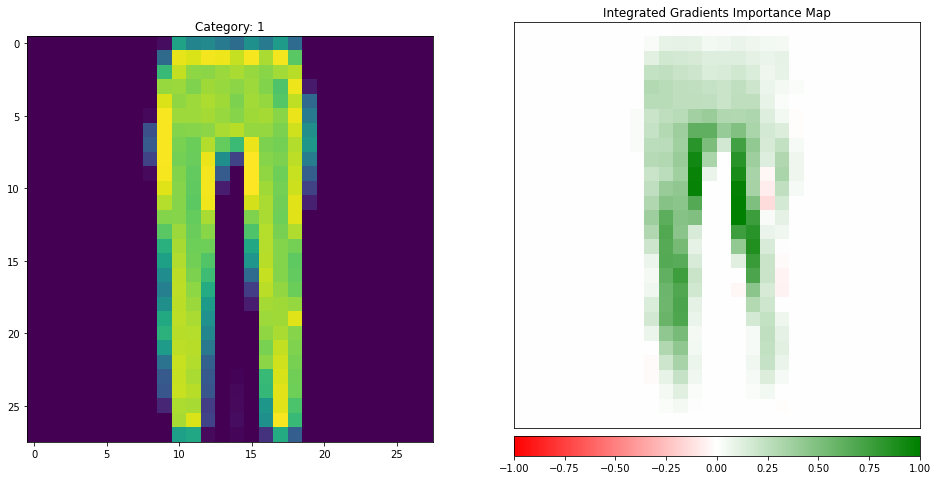

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd39ea9fb90>)

In [22]:
from captum.attr import IntegratedGradients

image_index = 2

input = test_imgs[image_index].unsqueeze(1)
explainer = IntegratedGradients(model)

attr = explainer.attribute(input, target=test_labels[image_index].item(),method='riemann_trapezoid')

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="all",
                             fig_size=(8,8),
                             title='Integrated Gradients Importance Map',
                             show_colorbar=True)



image_index = 0

input = test_imgs[image_index].unsqueeze(1)
explainer = IntegratedGradients(model)

attr = explainer.attribute(input, target=test_labels[image_index].item(),method='riemann_trapezoid')

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="all",
                             fig_size=(8,8),
                             title='Integrated Gradients Importance Map',
                             show_colorbar=True)


# Layer-wise relevance propagation

Layer-wise relevance propagation (LRP) is an explanation method that computes feature attributions by backpropagating relevance scores through the network layers from output to input. Relevance scores measure the connection strength between any two neurons.

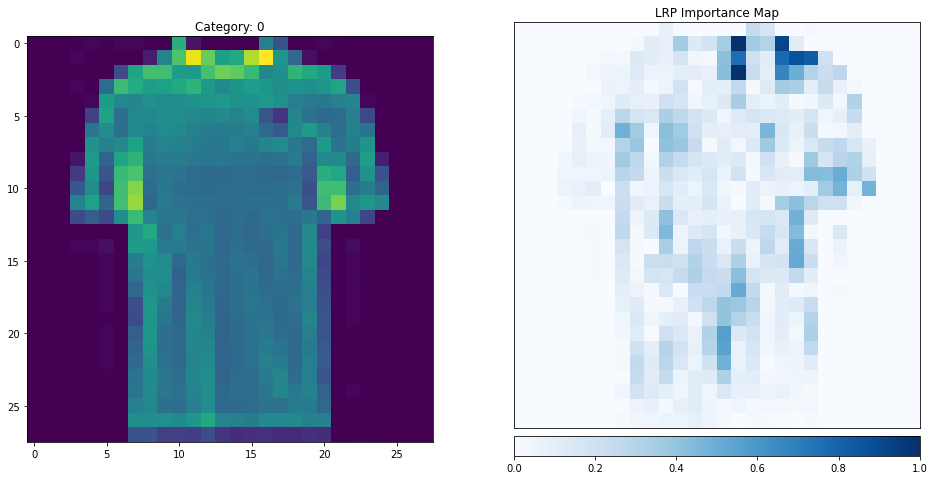

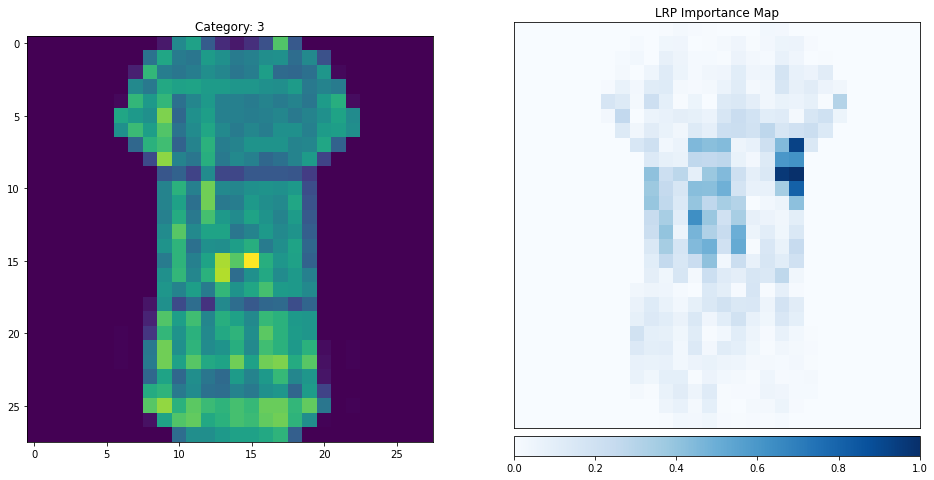

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3a8527650>)

In [23]:
from captum.attr import LRP

image_index = 3

input = test_imgs[image_index].unsqueeze(1)
explainer = LRP(model)

attr = explainer.attribute(input, target=test_labels[image_index].item())

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="absolute_value",
                             fig_size=(8,8),
                             title='LRP Importance Map',
                             show_colorbar=True)


image_index = 1

input = test_imgs[image_index].unsqueeze(1)
explainer = LRP(model)

attr = explainer.attribute(input, target=test_labels[image_index].item())

fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="absolute_value",
                             fig_size=(8,8),
                             title='LRP Importance Map',
                             show_colorbar=True)


# Excitation Backpropagation

Excitation Backpropagation (EBP) is an explanation method that aims to visualize neuron activations by applying a winner-take-all (WTA) approach to backpropagating through excitatory connections between neurons for classification tasks. It backpropagates only positive weights while keeping gradients normalized.

In [24]:
class EBLinear(Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_variables

        weight = weight.clamp(min=0) if torch.use_pos_weights else weight.clamp(max=0).abs()

        input.data = input.data - input.data.min() if input.data.min() < 0 else input.data
        grad_output /= input.mm(weight.t()).abs() + 1e-10 
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
            grad_input *= input
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias

def trainable_modules(orig, flat=None, param_only=True):
    flat = [] if flat is None else flat
    submodules = list(orig.children())
    if len(submodules) > 0:
        for m in submodules:
            flat += trainable_modules(m, flat=[])
    else:
        if param_only and len(list(orig.parameters())) > 0:
            return flat + [orig]
    return flat

def excitation_backprop(model, inputs, prob_outputs, contrastive=False, target_layer=0):
    inputs = Variable(inputs.data)
    inputs.requires_grad = True
    torch.use_pos_weights = True
    
    layer_top = trainable_modules(model)[-1]
    layer_target = trainable_modules(model)[target_layer]
    
    global top_h_, contr_h_, target_h_
    top_h_, contr_h_, target_h_ = None, None, None

    def hook_top_h(m, i, o): global top_h_ ; top_h_ = o
    def hook_contr_h(m, i, o): global contr_h_ ; contr_h_ = i[0]
    def hook_target_h(m, i, o): global target_h_ ; target_h_ = i[0]

    h1 = layer_top.register_forward_hook(hook_top_h)
    h2 = layer_top.register_forward_hook(hook_contr_h)
    h3 = layer_target.register_forward_hook(hook_target_h)
    
    _ = model(inputs)
    h1.remove()
    h2.remove()
    h3.remove()
    if target_layer == 0:
        target_h_ = inputs 

    if not contrastive:
        outputs = model(inputs)
        return torch.autograd.grad(top_h_, target_h_, grad_outputs=prob_outputs, retain_graph=True)[0]
    
    pos_evidence = torch.autograd.grad(top_h_, contr_h_, grad_outputs=prob_outputs.clone(), retain_graph=True)[0]
    torch.use_pos_weights = False
    neg_evidence = torch.autograd.grad(top_h_, contr_h_, grad_outputs=prob_outputs.clone(), retain_graph=True)[0]
    
    torch.use_pos_weights = True
    contrastive_signal = pos_evidence - neg_evidence
    return torch.autograd.grad(contr_h_, target_h_, grad_outputs=contrastive_signal, retain_graph=True)[0]

real_fs = []
real_fs.append(copy.deepcopy(torch.nn.functional.linear))
real_fs.append(copy.deepcopy(torch.nn.functional.conv1d))
real_fs.append(copy.deepcopy(torch.nn.functional.conv2d))
real_fs.append(copy.deepcopy(torch.nn.functional.conv3d))
real_fs.append(copy.deepcopy(torch.nn.functional.avg_pool2d))

def use_eb(use_eb, verbose=True):
    global real_torch_funcs
    if use_eb:
        torch.use_pos_weights = True
        if verbose: print("using excitation backprop autograd mode:")
        if verbose: print("\t->replacing torch.nn.functional.linear with eb_linear...")
        torch.nn.functional.linear = EBLinear.apply
        if verbose: print("\t->replacing torch.nn.functional.conv{1,2,3}d with eb_conv{1,2,3}d...")
        if verbose: print("\t->replacing torch.nn.functional.avg_pool2d with eb_avg_pool2d...")
    else:
        if verbose: print("using regular backprop autograd mode:")
        if verbose: print("\t->restoring torch.nn.backends.thnn.backend.Linear...")
        torch.nn.functional.linear = real_fs[0]
        if verbose: print("\t->restoring torch.nn.functional.conv{1,2,3}d...")
        if verbose: print("\t->restoring torch.nn.functional.avg_pool2d...")


class Dataloader():
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.modes = modes = ['train', 'test']
        trans = transforms.Compose([transforms.ToTensor(),])
        dsets = {k: datasets.FashionMNIST('./data', train=k=='train', download=True, transform=trans) for k in modes}
        self.loaders = {k: torch.utils.data.DataLoader(dsets[k], batch_size=batch_size, shuffle=True) for k in modes}

    def next(self, mode='train',sigma=0.8):
        X, y = next(iter(self.loaders[mode]))
        return Variable(X + sigma*torch.rand(X.shape)).view(self.batch_size, -1), Variable(y)

def accuracy(model, dataloader, mode='test'):
    correct = 0
    nbatches = int(10000/dataloader.batch_size)
    for _ in range(nbatches):
        X, y = dataloader.next(mode)
        pred = model(X).data.max(1)[1]
        correct += pred.eq(y.data).sum()
    return 100*correct/(dataloader.batch_size*nbatches)

class FMnistClassifier(nn.Module):
    def __init__(self, hdim=200):
        super(FMnistClassifier, self).__init__()
        self.linear1 = nn.Linear(28**2, hdim)
        self.linear2 = nn.Linear(hdim, hdim)
        self.linear3 = nn.Linear(hdim, 10)

    def forward(self, x):
        activations = []
        h1 = F.relu(self.linear1(x))
        h2 = F.relu(self.linear2(h1))
        h3 = self.linear3(h2)
        return h3

In [25]:
ebp_model = FMnistClassifier(hdim=128)
optimizer = torch.optim.Adam(ebp_model.parameters(), lr=3e-3)
dataloader = Dataloader(256)

global_step = 0
total_steps = 4000
test_every = int(total_steps/20)
running_loss = None
acc_msg = '...'
loss_hist = []
acc_hist = []

for global_step in range(global_step, total_steps+global_step+1):

    X, y = dataloader.next()
    logits = ebp_model(X)
    y_hat = F.log_softmax(logits, dim=-1)
    loss = F.nll_loss(y_hat, y)
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

    np_loss = loss.data.numpy()
    running_loss = np_loss if running_loss is None else .99*running_loss + (1-.99)*np_loss
    loss_hist.append(running_loss)

    if global_step % test_every == 0:
        a = accuracy(ebp_model, dataloader, mode='test')
        acc_hist.append(a)
        acc_msg = 'accuracy: {:.4f}%'.format(a)
        print('\tstep {}/{} | {} | loss: {:.4f}'.format(global_step, total_steps, acc_msg, running_loss), end="\n")


	step 0/4000 | accuracy: 20.7833% | loss: 2.3119
	step 200/4000 | accuracy: 77.9748% | loss: 0.8845
	step 400/4000 | accuracy: 79.8578% | loss: 0.5738
	step 600/4000 | accuracy: 81.5605% | loss: 0.5043
	step 800/4000 | accuracy: 80.5789% | loss: 0.4740
	step 1000/4000 | accuracy: 81.1699% | loss: 0.4546
	step 1200/4000 | accuracy: 82.9427% | loss: 0.4442
	step 1400/4000 | accuracy: 81.9211% | loss: 0.4319
	step 1600/4000 | accuracy: 83.1631% | loss: 0.4277
	step 1800/4000 | accuracy: 83.1430% | loss: 0.4250
	step 2000/4000 | accuracy: 83.3133% | loss: 0.4187
	step 2200/4000 | accuracy: 83.4235% | loss: 0.4050
	step 2400/4000 | accuracy: 83.2632% | loss: 0.4041
	step 2600/4000 | accuracy: 84.2248% | loss: 0.3953
	step 2800/4000 | accuracy: 83.8942% | loss: 0.3834
	step 3000/4000 | accuracy: 84.2047% | loss: 0.3830
	step 3200/4000 | accuracy: 85.3065% | loss: 0.3800
	step 3400/4000 | accuracy: 84.2849% | loss: 0.3770
	step 3600/4000 | accuracy: 84.8458% | loss: 0.3755
	step 3800/4000 | a

using excitation backprop autograd mode:
	->replacing torch.nn.functional.linear with eb_linear...
	->replacing torch.nn.functional.conv{1,2,3}d with eb_conv{1,2,3}d...
	->replacing torch.nn.functional.avg_pool2d with eb_avg_pool2d...


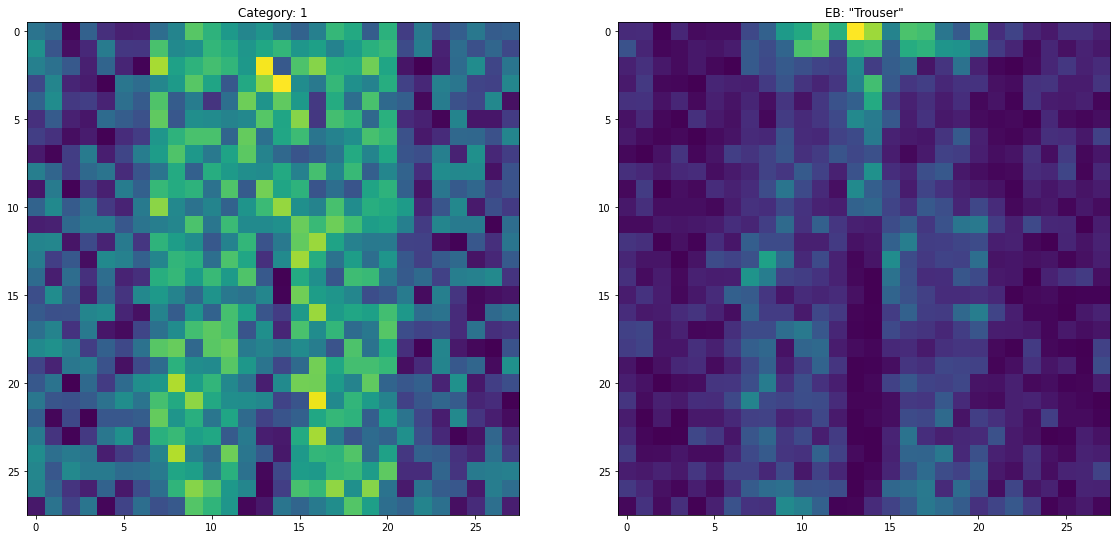

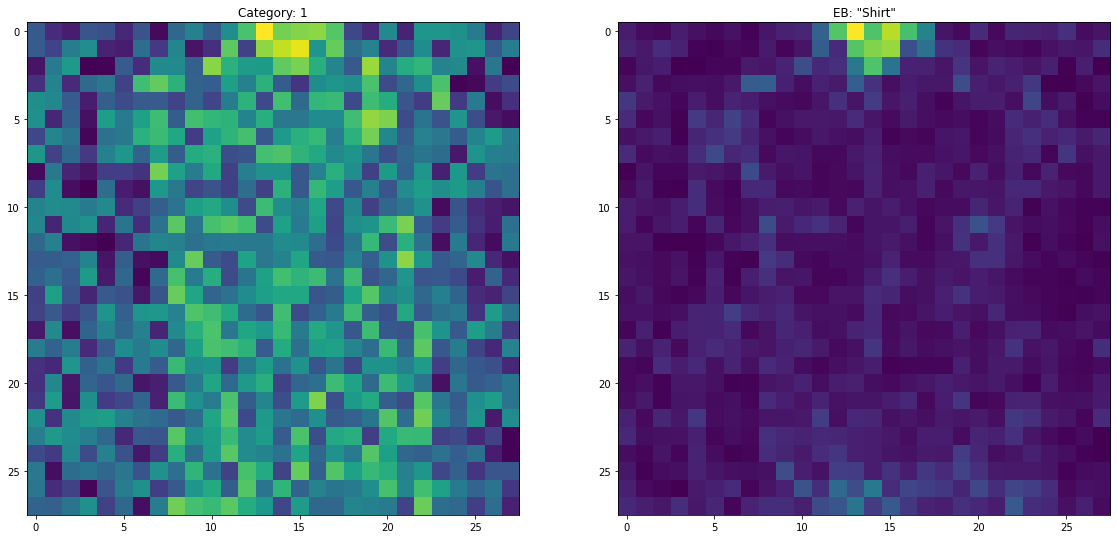

In [26]:
use_eb(True)

class_labels = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
X, y = dataloader.next(mode='test')
inputs = inputs = X[0:1,:]

true_id = y.data[0]
prob_outputs_true = Variable(torch.zeros(1,10)) ; prob_outputs_true.data[:,true_id] += 1
prob_inputs_true = excitation_backprop(ebp_model, inputs, prob_outputs_true, contrastive=False)

beta = 0.5
true_img = prob_inputs_true.view(28,28).data.numpy()

s = 10
f = plt.figure(figsize=[s*3,s])
plt.subplot(1,3,1)
plt.title('Category: 1')
plt.imshow(inputs.data.view(28,28).numpy())

plt.subplot(1,3,2)
plt.title('EB: "{}"'.format(class_labels[true_id][:15]))
plt.imshow(true_img)
plt.show()

inputs = inputs = X[2:3,:]

true_id = y.data[2]
prob_outputs_true = Variable(torch.zeros(1,10)) ; prob_outputs_true.data[:,true_id] += 1
prob_inputs_true = excitation_backprop(ebp_model, inputs, prob_outputs_true, contrastive=False)

beta = 0.5
true_img = prob_inputs_true.view(28,28).data.numpy()

s = 10
f = plt.figure(figsize=[s*3,s])
plt.subplot(1,3,1)
plt.title('Category: 1')
plt.imshow(inputs.data.view(28,28).numpy())

plt.subplot(1,3,2)
plt.title('EB: "{}"'.format(class_labels[true_id][:15]))
plt.imshow(true_img)
plt.show() 

# GradCam

Gradient-weighed CAM (GradCAM) is a generalization of Class Activation Maps to allow for more flexible CNN architectures. Instead of relying on a global average pooling after the last convolutional layer, it allows for any architecture as long as layers are differentiable. GradCAM assigns importance values to each neuron by utilizing the gradient information that flows into the last convolutional layer of the CNN.

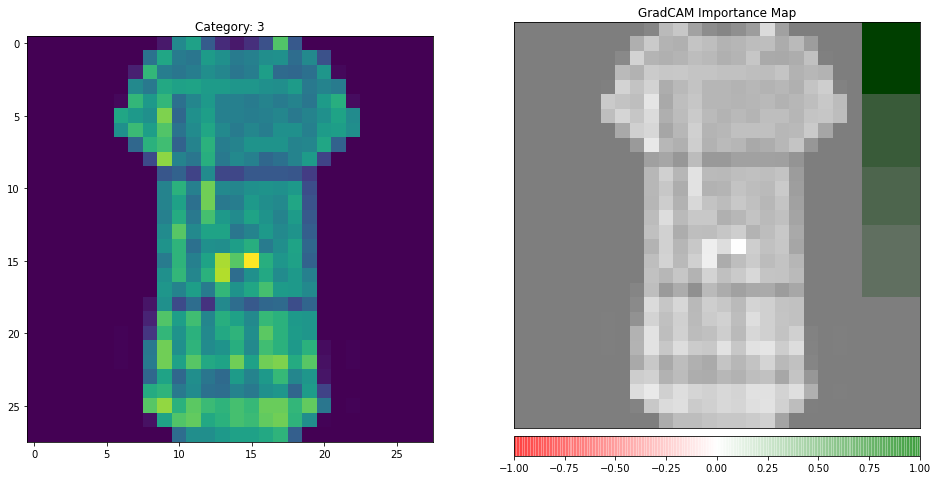

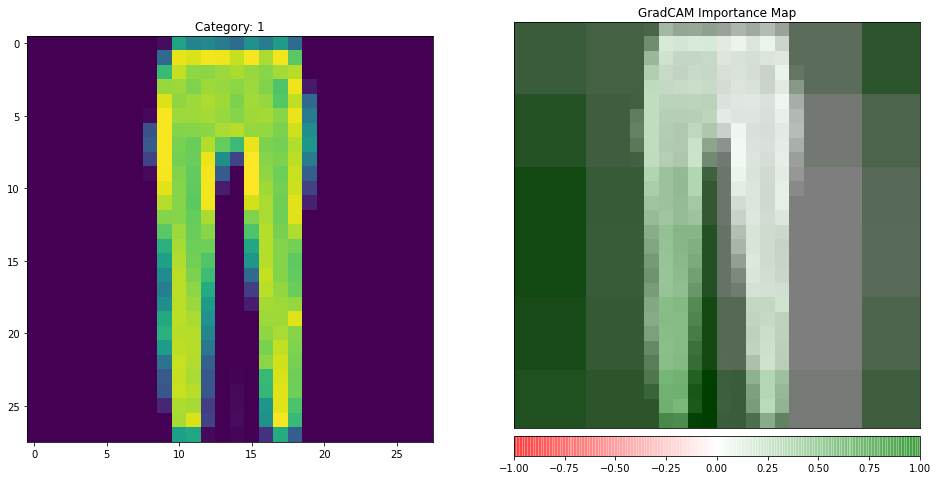

(<Figure size 1152x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd39cb2bf50>)

In [27]:
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution

image_index = 1

input = test_imgs[image_index].unsqueeze(1)
explainer = LayerGradCam(model,model.conv3)

attr = explainer.attribute(input, target=test_labels[image_index].item(),relu_attributions=True)
upsampled_attr = LayerAttribution.interpolate(attr, (28, 28))


fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = upsampled_attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="blended_heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="all",
                             fig_size=(8,8),
                             title='GradCAM Importance Map',
                             show_colorbar=True)


image_index = 0

input = test_imgs[image_index].unsqueeze(1)
explainer = LayerGradCam(model,model.conv3)

attr = explainer.attribute(input, target=test_labels[image_index].item(),relu_attributions=True)
upsampled_attr = LayerAttribution.interpolate(attr, (28, 28))


fig, ax = plt.subplots(1,2,figsize = (16, 10))

ax[0].imshow(test_imgs.squeeze().numpy()[image_index])
ax[0].set_title("Category: {}".format(test_labels[image_index].item()))

attribution_map = upsampled_attr.squeeze(1).detach().numpy()
attribution_map = np.transpose(attribution_map,(1,2,0))
viz.visualize_image_attr(attribution_map,
                             original_image=np.transpose(input.squeeze(1),(1,2,0)).numpy(),
                             method="blended_heat_map",
                             plt_fig_axis=(fig,ax[1]),
                             sign="all",
                             fig_size=(8,8),
                             title='GradCAM Importance Map',
                             show_colorbar=True)

